<a href="https://colab.research.google.com/github/AdrianCPC/Robot_trading_DS/blob/main/Robot_Trading_DS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#1 .Configuración del ambiente

In [ ]:
#Determinacion de versiones disponibles para trabajar en el notebook
!python -V
print('------')
!pip show Pandas | grep 'Name\|Version'
print('------')
!pip show Numpy | grep 'Name\|Version'
print('------')
!pip show Matplotlib | grep 'Name\|Version'

Python 3.10.12
------
Name: pandas
Version: 1.5.3
------
Name: numpy
Version: 1.23.5
------
Name: matplotlib
Version: 3.7.1


##Importacion de bibliotecas

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
from urllib.request import urlopen
from bs4 import BeautifulSoup
import requests
from IPython.display import clear_output
import time

##Variables Globales

In [ ]:
global df_bitcoin, precio_actual, tendencia, media_bitcoin,  algoritmo_decision

##Datos Historicos del Bitcoin

In [ ]:
#extrayendo datos historicos de coindesk

url = 'https://api.coindesk.com/v1/bpi/historical/close.json?start=2022-01-10&end=2023-01-10'

response = pd.read_json(url)

df = pd.DataFrame(response['bpi']).rename(columns={'bpi':'price'})
df.index = pd.to_datetime(df.index, errors='coerce')
df = df.dropna()



In [ ]:
df.head(-1)

,price
2022-01-10,41838.4617
2022-01-11,42744.2900
2022-01-12,43921.2833
2022-01-13,42577.1583
2022-01-14,43095.5250
...,...
2022-07-02,19188.5217
2022-07-03,19115.5200
2022-07-04,19129.0000
2022-07-05,20205.6075


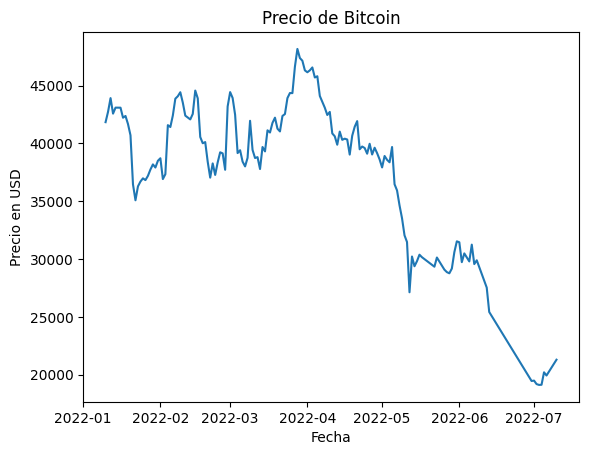

In [ ]:
# Grafica de los historicos


import matplotlib.pyplot as plt

plt.plot(df)
plt.title('Precio de Bitcoin')
plt.xlabel('Fecha')
plt.ylabel('Precio en USD')
plt.show()

#2. Obtención de datos

In [ ]:

#Extracción de datos historicos de precios del bitcoin en dolares BTC-USD(7 días - intervaloes de 5 minnutos)
def importar_base_bitcoin():
  global df_bitcoin

  symbol = "BTC-USD"
  date_start = pd.Timestamp.now() - pd.DateOffset(days=7)
  date_end = pd.Timestamp.now()


  df_bitcoin = yf.download(symbol, start=date_start, end=date_end, interval="5m")


In [ ]:
importar_base_bitcoin()

[*********************100%%**********************]  1 of 1 completed


In [ ]:
df_bitcoin.head(-1)

,Open,High,Low,Close,Adj Close,Volume
Datetime,,,,,,
2023-08-18 02:40:00+00:00,26574.687500,26577.626953,26536.398438,26536.398438,26536.398438,0
2023-08-18 02:45:00+00:00,26517.433594,26550.337891,26517.433594,26545.001953,26545.001953,31504384
2023-08-18 02:50:00+00:00,26520.912109,26552.564453,26520.912109,26547.580078,26547.580078,18937856
2023-08-18 02:55:00+00:00,26531.847656,26531.847656,26498.779297,26498.779297,26498.779297,172572672
2023-08-18 03:00:00+00:00,26485.591797,26497.679688,26479.474609,26497.679688,26497.679688,21751808
...,...,...,...,...,...,...
2023-08-25 02:10:00+00:00,26143.302734,26145.054688,26141.941406,26145.054688,26145.054688,4825088
2023-08-25 02:15:00+00:00,26142.171875,26142.171875,26136.716797,26136.716797,26136.716797,3953664
2023-08-25 02:20:00+00:00,26142.615234,26150.525391,26141.943359,26150.525391,26150.525391,520192


In [ ]:
#Extraccion del precio actual del BTC y variacion del precio en la ultima hora usando Web Scraping
def extraer_tendencias():
  global precio_actual, tendencia

  headers = {'User-Agent':'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/114.0.0.0 Safari/537.36 OPR/100.0.0.0'}
  url = "https://coinmarketcap.com/"
  page = requests.get(url,headers=headers)
  soup = BeautifulSoup(page.content, features="lxml")


  #Busqueda precio actual BTC en tabla
  actual_price_table = soup.find('table', class_="sc-dba2d818-3 iWUxTT cmc-table")
  btc_row = actual_price_table.find_all('tr')[1]
  all_columns = btc_row.find_all('td')
  precio_actual = float(all_columns[3].get_text().replace("$", "").replace(",", ""))

  #print("Precio Actual del Bitcoin: $", precio_actual)





In [ ]:
extraer_tendencias()

Precio Actual del Bitcoin: $ 26096.44


In [ ]:

  #Variacion precio ultima hora
  variacion_1h_element = soup.find("span", text="1h")
  variacion_1h_parent = variacion_1h_element.find_parent("div", class_="sc-15yy2pl-0 cPmGKC priceChange___3Hie7")
  variacion_1h_text = variacion_1h_parent.find("span").text.strip()
  variacion_1h = float(variacion_1h_text.replace("%", ""))

  precio_actual = float(precio_actual_text.replace("$", "").replace(",", ""))
  tendencia = "baja" if variacion_1h < 0 else "alta"

  #Tendencias
  tendencia = "baja" if variacion_1h < 0 else "alta"

AttributeError: ignored

#3. Limpieza de datos

#4. Tomar decisiones

#5. Visualización

#6. Automatización